# Практический проект по анализу данных 

Проанализируем активность студентов онлайн курса [Введение в анализ данных в R](https://stepik.org/course/129/syllabus).

Описание данных:

**events_train.csv** - данные о действиях, которые совершают студенты со стэпами:

1. **step_id** - id стэпа
2. **user_id** - анонимизированный id юзера
3. **timestamp** - время наступления события в формате unix date
4. **action** - событие, возможные значения: 
    - discovered - пользователь перешел на стэп
    - viewed - просмотр шага,
    - started_attempt - начало попытки решить шаг, ранее нужно было явно нажать на кнопку - начать решение, перед тем как приступить к решению практического шага
    - passed - удачное решение практического шага

**submissions_train.csv** - данные о времени и статусах сабмитов к практическим задания

1. **step_id** - id стэпа
2. **timestamp** - время отправки решения в формате unix date
3. **submission_status** - статус решения
4. **user_id** - анонимизированный id юзера





In [359]:
import pandas as pd
import numpy as np

In [360]:
% matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [361]:
sns.set(rc={'figure.figsize': (9, 6)})

In [362]:
events_data = pd.read_csv('data/event_data_train.zip', compression='zip')

In [363]:
events_data.head()

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


Немного поизучаем данные и добавим столбцы **date** и **day**.

In [364]:
events_data.action.unique()

array(['viewed', 'passed', 'discovered', 'started_attempt'], dtype=object)

In [365]:
events_data['date'] = pd.to_datetime(events_data.timestamp, unit='s')
events_data.head()

,step_id,timestamp,action,user_id,date
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48
1,32815,1434340848,passed,17632,2015-06-15 04:00:48
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35


In [366]:
events_data.dtypes

step_id               int64
timestamp             int64
action               object
user_id               int64
date         datetime64[ns]
dtype: object

In [367]:
events_data['day'] = events_data.date.dt.date

Посчитаем сколько уникальных пользователей посещают курс в каждый заданный день. Для этого сгруппируем данные по столбцу **day** и воспользуемся функцией `nunique`.

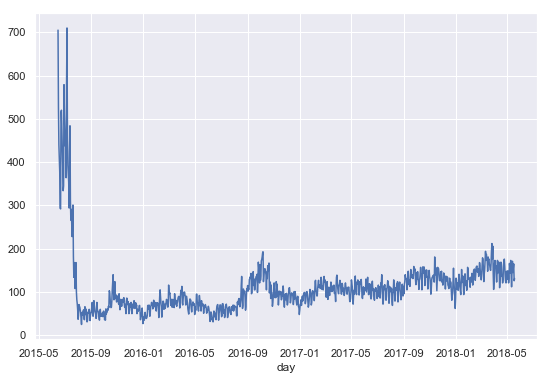

In [368]:
events_data.groupby('day').user_id.nunique().plot()

Теперь сгруппируем данные по пользователям и построим гистограмму количества пройденных степов. Не забываем переименовать колонку `step_id` в корректную для данного контекста `passed_steps`.

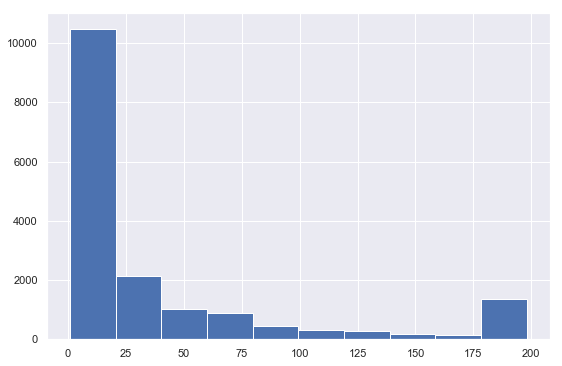

In [369]:
events_data[events_data.action  == 'passed'].groupby('user_id', as_index=False)\
        .agg({'step_id': 'count'})\
        .rename(columns={'step_id': 'passed_steps'}).passed_steps.hist()

Казалось бы, график построен верно. Однако заметим, что при построении гистограммы мы не учли пользователей, которые записались на курс, но не прошли ни одного степа. Вспользуемся функцией создания сводных таблиц - `pivot_table`, для более правильного решения.

In [370]:
users_events_data = events_data.pivot_table(index='user_id',
                                            columns='action',
                                            values='step_id', 
                                            aggfunc='count', 
                                            fill_value=0)
users_events_data.head()

action,discovered,passed,started_attempt,viewed
user_id,,,,
1,1,0,0,1
2,9,9,2,10
3,91,87,30,192
5,11,11,4,12
7,1,1,0,1


Обычно не очень удобно, когда в качестве индексов используется одна из колонок с данными. Поэтому исправим представление данных с помощью `reset_index`.

In [371]:
users_events_data = users_events_data.reset_index()
users_events_data.head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


In [372]:
print(users_events_data.columns.name) 
users_events_data.columns.name = ''
users_events_data.head()

action


,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


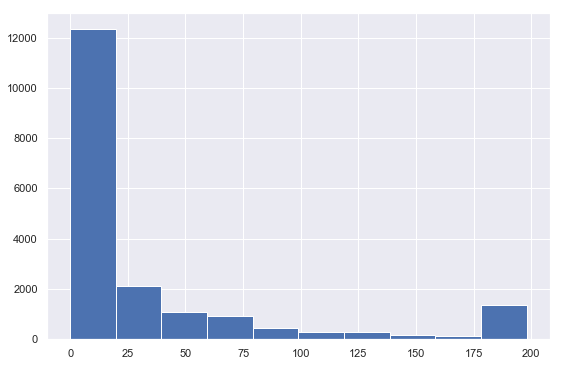

In [373]:
users_events_data.passed.hist()

Итак, видим, что гистограмма получилось чуть другой, т.к. теперь мы учли пользователей, которые не прошли ни одного степа.

Такую же сводную таблицу построим для файла `submissions_data.csv`.

In [374]:
submissions_data = pd.read_csv('data/submissions_data_train.zip', compression='zip')

In [375]:
submissions_data['date'] = pd.to_datetime(submissions_data.timestamp, unit='s')
submissions_data.head()
submissions_data['day'] = submissions_data.date.dt.date
submissions_data.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


In [376]:
users_scores_in_submissions = submissions_data.pivot_table(index='user_id', 
                                            columns='submission_status',
                                            values='step_id',
                                            aggfunc='count', 
                                            fill_value=0).reset_index()

In [377]:
users_scores_in_submissions.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


## Нахождение длительности промежутка бездействия пользователя на курсе

Поставим конкретную задачу для анализа. Наша глобальная цель - предсказывать тех пользователей, которые покидают курс, не пройдя его до конца. Что для этого можно сделать? Заметим для начала, что важно разделять пользователей, которые временно приостановили прохождение курса, но планируют вернуться и пользователей, которые уже точно не вернутся на курс. Как можно отличить одних от других? Например, мы можем исследовать активность пользователя с течением времени, и в случае, если на протяжении $n$ дней пользователь не возвращался к курсу, то будем считать, что он уже не вернется. Попробуем определить, чему должно равняться $n$.

Для этого сначала рассчитаем для каждого пользователя длительность перерывов между активностями на курсе. Далее посмотрим на картину в целом по всем пользователям и примем какое-то статистическое решение о том какую величину $n$ можно считать пороговой, чтобы относить пользователя к категории покинувших курс.


In [378]:
gap_data = events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day'])\
    .groupby('user_id')['timestamp'].apply(list)\
    .apply(np.diff).values
gap_data

array([array([], dtype=int32), array([4843602]),
       array([6899249,  182484,   93710, 2768870,  171400,   78712]), ...,
       array([   86128,   136759,    94899,  1422583, 14347289,   505061,
          98252,    57019]),
       array([1567990]), array([], dtype=int32)], dtype=object)

Теперь объединим все данные в один массив, где каждый элемент будет представлять собой длительность промежутка бездействия пользователя (в днях) и построим гистограмму.

In [379]:
gap_data = pd.Series(np.concatenate(gap_data, axis=0))
gap_data = gap_data/ (24*60*60)
gap_data[:10]

0     56.060208
1     79.852419
2      2.112083
3      1.084606
4     32.047106
5      1.983796
6      0.911019
7    390.078843
8      9.994028
9      0.589468
dtype: float64

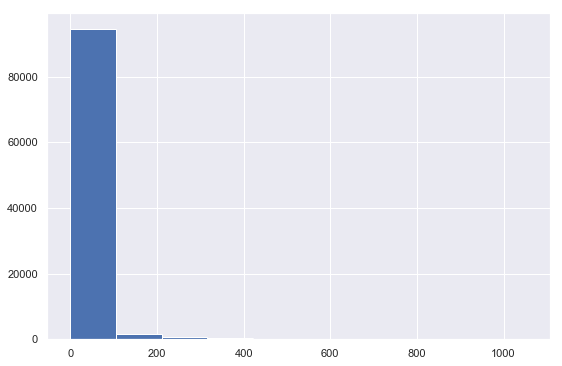

In [380]:
gap_data.hist()

График получился не очень содержательный, т.к. у нас есть большие выбросы. Это частая проблема, поэтому необходимо отфильтровать данные от выбросов. Для этого уберем совсем большие наблюдения (те, у которых перерыв больше 200 дней).

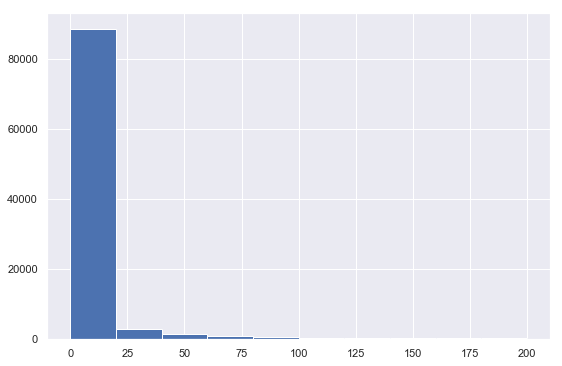

In [381]:
gap_data[gap_data < 200].hist()

Посмотрим какой порог времени бездействия не превышают 90% и 95% пользователей.

In [382]:
print(gap_data.quantile(0.95), "дней")
print(gap_data.quantile(0.90), "дней")

59.760440972222156 дней
18.325995370370403 дней


Итак, получили, что величина перерывов у 95% пользователей укладывается в 59 дней, а у 90% пользователей в 18 дней. На основании этих данных возьмем, скажем, 30 дней в качестве порогового значения промежутка бездействия.


## Разметка пользователей 

Итак, давайте теперь разметим наших пользователей по принципу того являются ли они уже "дропнувшимися" или нет. При этом нужно понимать, что если пользователь долгое время не появляется на курсе, но при этом курс уже им пройден, то такого пользователя нельзя считать "дронувшимся".

Имеем составное условие: если человек еще не получил сертификат и при этом более 30 дней отсутствует на платформе, то помечаем его, как покинувшего курс.


In [383]:
events_data.tail()

,step_id,timestamp,action,user_id,date,day
3480698,33375,1526772685,viewed,11677,2018-05-19 23:31:25,2018-05-19
3480699,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19
3480700,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19
3480701,32815,1526772750,passed,5198,2018-05-19 23:32:30,2018-05-19
3480702,33892,1526772811,viewed,18526,2018-05-19 23:33:31,2018-05-19


В переменную `now` запишем время (`timestamp`) последнего события среди всех пользователей. В переменную `dropout_threshold` - значение 30 дней в линуксовом формате времени.

In [384]:
now = events_data['timestamp'].max()
dropout_threshold = 30 * 24 * 60 * 60
print('Time now:', now, '\nDropout threshold:', dropout_threshold)

Time now: 1526772811 
Dropout threshold: 2592000


In [385]:
users_data = events_data.groupby('user_id', as_index=False).\
            aggregate({'timestamp': 'max'}).rename(columns = {'timestamp': 'last_timestamp'})
users_data.head()

,user_id,last_timestamp
0,1,1472827464
1,2,1519226966
2,3,1444581588
3,5,1499859939
4,7,1521634660


In [386]:
users_data['is_gone_user'] = (now - users_data.last_timestamp) > dropout_threshold
users_data.head()

,user_id,last_timestamp,is_gone_user
0,1,1472827464,True
1,2,1519226966,True
2,3,1444581588,True
3,5,1499859939,True
4,7,1521634660,True


Присоединим к полученной таблице датафрейм с числом попыток решения степов и числом набранных баллов.

In [387]:
users_scores_in_submissions.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


In [388]:
users_data = users_data.merge(users_scores_in_submissions, on='user_id', how='outer')
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong
0,1,1472827464,True,NaN,NaN
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,True,NaN,NaN


In [389]:
users_data = users_data.fillna(0)
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong
0,1,1472827464,True,0.0,0.0
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,True,0.0,0.0


К полученной таблице присоединим еще один датафрейм с информацией о прочих действиях пользователя.

In [390]:
users_data = users_data.merge(users_events_data, how='outer')
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed
0,1,1472827464,True,0.0,0.0,1,0,0,1
1,2,1519226966,True,2.0,0.0,9,9,2,10
2,3,1444581588,True,29.0,23.0,91,87,30,192
3,5,1499859939,True,2.0,2.0,11,11,4,12
4,7,1521634660,True,0.0,0.0,1,1,0,1


Добавим еще один столбец с количеством дней, проведенных на курсе для каждого пользователя.

In [391]:
users_days = events_data.groupby('user_id').day.nunique().to_frame().reset_index()
users_days = users_days.rename(columns={'day': 'unique_days'})
users_days.head()

,user_id,unique_days
0,1,1
1,2,2
2,3,7
3,5,2
4,7,1


In [392]:
users_data = users_data.merge(users_days, how='outer')
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,unique_days
0,1,1472827464,True,0.0,0.0,1,0,0,1,1
1,2,1519226966,True,2.0,0.0,9,9,2,10,2
2,3,1444581588,True,29.0,23.0,91,87,30,192,7
3,5,1499859939,True,2.0,2.0,11,11,4,12,2
4,7,1521634660,True,0.0,0.0,1,1,0,1,1


Обязательно проверям, что мы никого не потеряли.

In [393]:
print(users_data.user_id.nunique(), ' is equal', events_data.user_id.nunique())

19234  is equal 19234


Заведем еще одну колонку в данных, показывающию успешно ли пользователь закончил курс.

In [394]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,unique_days
0,1,1472827464,True,0.0,0.0,1,0,0,1,1
1,2,1519226966,True,2.0,0.0,9,9,2,10,2
2,3,1444581588,True,29.0,23.0,91,87,30,192,7
3,5,1499859939,True,2.0,2.0,11,11,4,12,2
4,7,1521634660,True,0.0,0.0,1,1,0,1,1


In [395]:
users_data['passed_course'] = users_data.passed > 170
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,unique_days,passed_course
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False


In [396]:
users_data.groupby('passed_course').count()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,unique_days
passed_course,,,,,,,,,,
False,17809,17809,17809,17809,17809,17809,17809,17809,17809,17809
True,1425,1425,1425,1425,1425,1425,1425,1425,1425,1425


Найдем процент пользователей, успешно прошедших курс.

In [397]:
print('Успешно прошло курс {0:.2}% пользователей'.format(100*1425/(17809 + 1425)))

Успешно прошло курс 7.4% пользователей


## Переходим к машинному обучению
Итак, наши данные уже почти размечены и приведены к такому виду, чтобы их можно было подать на вход ML алгоритму.

Вспомним нашу цель: мы хотим как можно раньше предсказывать по поведению пользователя уйдет ли он с курса или нет. Ясно, что если мы будем слишком поздно предсказывать уход пользователя, то такой алгоритм окажется бесполезным. Поэтому нужно попробовать разные пороги и найти оптимальный баланс времени и качества. 

Для начала попробуем делать прогноз, основываясь на 3 днях пользования курсом. Но сначала проверем на адекватность эту величину, т.к. мы взяли и ее произвоьным образом. Для этого подсчитаем медиану количества уникальных дней, проведенных пользователями на курсе. Причем будем делать подсчет только среди тех пользователей, которые успешно прошли курс.

In [398]:
users_data[users_data.passed_course].unique_days.median()

20.0

Видим, что медиана равна 20 дням. Нариусем также гистограмму и отметим, что она имеет типично скошенную метрику. Это довольно интересное наблюдение: на практике большинство метрик, которые как-то характеризуют взаимодействие пользователя с продуктом, очень часто распределены не нормально.

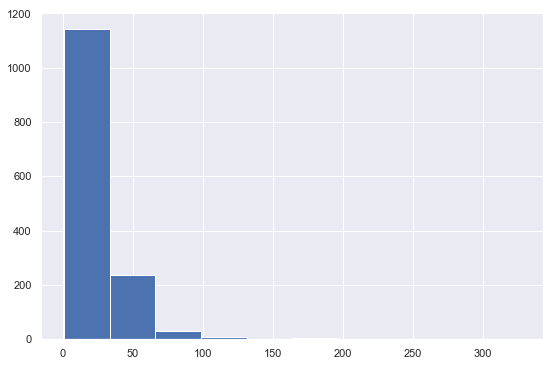

In [399]:
users_data[users_data.passed_course].unique_days.hist()

Итак, наша первая задача отобрать события, которые происходили с пользователем в течение первых 3-ех дней, из общего датафрейма `events_data`. Для начала создадим датафрейм, где будет собраны данные о первой активности каждого пользователя на курсе:

In [400]:
user_min_time = events_data.groupby('user_id', as_index=False).\
                agg({'timestamp': 'min'}).rename({'timestamp': 'min_timestamp'}, axis=1)

In [401]:
user_min_time.head()

,user_id,min_timestamp
0,1,1472827464
1,2,1514383364
2,3,1434358476
3,5,1466156809
4,7,1521634660


In [402]:
users_data = users_data.merge(user_min_time, how='outer')
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,unique_days,passed_course,min_timestamp
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False,1472827464
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False,1514383364
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False,1434358476
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False,1466156809
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False,1521634660


Вообще говоря, отобрать события, которые происходили с пользователем в течение первых 3-ех дней, не самая тривиальная задача. Ее можно решить несколькими способами. Рассмотрим первый и не самый оптимальный способ через цикл `for`:

In [403]:
events_data_train = pd.DataFrame()

In [404]:
for user_id in users_data.user_id:
    min_user_time = users_data[users_data.user_id == user_id].min_timestamp.item()
    time_threshold = min_user_time + 3*24*60*60
    user_evnts_data = events_data[(events_data.user_id == user_id) & (events_data.timestamp < time_threshold)]
    events_data_train = events_data_train.append(user_evnts_data)
    break

In [405]:
events_data_train

,step_id,timestamp,action,user_id,date,day
1347416,31981,1472827464,viewed,1,2016-09-02 14:44:24,2016-09-02
1347417,31981,1472827464,discovered,1,2016-09-02 14:44:24,2016-09-02


Мы специально сделали только одну итерацию, т.к. этот подход очень ресурсозатратен по времени. Более правильным способом было бы произвести нужную нам фильтрацию с помощью функционала pandas. Сделаем это снова двумя способами. 

Первый способ (самый оптимальный):

In [406]:
learning_time_threshold = 3*24*60*60

In [407]:
events_data = events_data.merge(user_min_time, how = 'outer')
events_data_train = events_data.query("timestamp <= min_timestamp + @learning_time_threshold")

In [408]:
events_data_train.shape

(1014985, 7)

In [528]:
events_data_train.head()

,step_id,timestamp,action,user_id,date,day,min_timestamp,user_time,user_learning_time_threshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,1434340848,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,1434340848,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,1434340848,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,1434340848,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,1434340848,17632_1434340895,17632_1434600048


In [529]:
# events_data_3_days = user_min_time.merge(events_data, on='user_id', how='outer')
# events_data_3_days['diff_timestamp'] = (events_data_3_days.timestamp - events_data_3_days.min_timestamp)
# events_data_3_days.query('diff_timestamp <= @learning_time_threshold').shape

Второй способ немного более странный, но тоже имеет место быть (с конкатенацией строк). Создадим новую колонку `user_time` и сконкатенируем `user_id` с `timestamp`:

In [530]:
events_data['user_time'] = events_data.user_id.map(str) + '_' + events_data.timestamp.map(str)

In [531]:
events_data.head()

,step_id,timestamp,action,user_id,date,day,min_timestamp,user_time,user_learning_time_threshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,1434340848,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,1434340848,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,1434340848,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,1434340848,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,1434340848,17632_1434340895,17632_1434600048


In [532]:
events_data.shape

(3480703, 9)

In [533]:
user_learning_time_threshold = user_min_time.user_id.map(str) + '_' + (user_min_time.min_timestamp + learning_time_threshold).map(str)

Получили серию где каждая запись состоит из айди пользователя сконкатенированного с значением времени, после которого мы уже не будем эти данные использовать.

In [534]:
user_learning_time_threshold.head()

0    1_1473086664
1    2_1514642564
2    3_1434617676
3    5_1466416009
4    7_1521893860
dtype: object

In [535]:
user_min_time['user_learning_time_threshold'] = user_learning_time_threshold

In [536]:
events_data = events_data.merge(user_min_time[['user_id', 'user_learning_time_threshold']], how='outer')

In [537]:
events_data.head()

,step_id,timestamp,action,user_id,date,day,min_timestamp,user_time,user_learning_time_threshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,1434340848,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,1434340848,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,1434340848,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,1434340848,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,1434340848,17632_1434340895,17632_1434600048


In [538]:
events_data_train = events_data[events_data.user_time <= events_data.user_learning_time_threshold]

In [539]:
events_data_train.head()

,step_id,timestamp,action,user_id,date,day,min_timestamp,user_time,user_learning_time_threshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,1434340848,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,1434340848,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,1434340848,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,1434340848,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,1434340848,17632_1434340895,17632_1434600048


Выполним проверку, что все подсчитано правильно:

In [542]:
events_data_train.groupby('user_id').day.nunique().max()

4

Итак, 4 дня это приемлемый результат. Т.к. если пользователь начал проходить курс 1-го мая в 21:00, то через трое суток будет уже 4-ое мая. Итого будем иметь 4 уникальных дня. А больше 4-ех дней быть не должно.

Подготовим такой же датасет на основе `submission_data`. 

In [550]:
submissions_data = submissions_data.merge(user_min_time, how = 'outer')
submission_data_train = submissions_data.query("timestamp <= min_timestamp + @learning_time_threshold")

In [551]:
submissions_data.head()

,step_id,timestamp,submission_status,user_id,date,day,max_timestamp,min_timestamp,user_learning_time_threshold
0,31971.0,1.434349e+09,correct,15853,2015-06-15 06:21:15,2015-06-15,1.479734e+09,1434345977,15853_1434605177
1,31972.0,1.434348e+09,correct,15853,2015-06-15 06:05:00,2015-06-15,1.479734e+09,1434345977,15853_1434605177
2,31972.0,1.478852e+09,wrong,15853,2016-11-11 08:15:49,2016-11-11,1.479734e+09,1434345977,15853_1434605177
3,31972.0,1.478852e+09,correct,15853,2016-11-11 08:16:04,2016-11-11,1.479734e+09,1434345977,15853_1434605177
4,31976.0,1.434348e+09,wrong,15853,2015-06-15 06:02:03,2015-06-15,1.479734e+09,1434345977,15853_1434605177


In [552]:
submission_data_train.head()

,step_id,timestamp,submission_status,user_id,date,day,max_timestamp,min_timestamp,user_learning_time_threshold
0,31971.0,1.434349e+09,correct,15853,2015-06-15 06:21:15,2015-06-15,1.479734e+09,1434345977,15853_1434605177
1,31972.0,1.434348e+09,correct,15853,2015-06-15 06:05:00,2015-06-15,1.479734e+09,1434345977,15853_1434605177
4,31976.0,1.434348e+09,wrong,15853,2015-06-15 06:02:03,2015-06-15,1.479734e+09,1434345977,15853_1434605177
5,31976.0,1.434348e+09,correct,15853,2015-06-15 06:03:08,2015-06-15,1.479734e+09,1434345977,15853_1434605177
7,31977.0,1.434347e+09,correct,15853,2015-06-15 05:49:31,2015-06-15,1.479734e+09,1434345977,15853_1434605177


Опять же не забываем сделать проверку, чтобы не ошибиться.

In [606]:
submission_data_train.groupby('user_id').day.nunique().max()

4

Наконец, соберем датфрейм с тренировочной выборкой.

In [632]:
X = submission_data_train.groupby('user_id').day.nunique().to_frame().reset_index()\
        .rename(columns={'day': 'days'})
X.head()

,user_id,days
0,2,1
1,3,1
2,8,1
3,14,1
4,16,3


In [633]:
X.shape

(8913, 2)

In [634]:
steps_tried = submission_data_train.groupby('user_id').step_id.nunique().to_frame().reset_index()\
        .rename(columns={'step_id': 'steps_tried'})

In [635]:
steps_tried.head()

,user_id,steps_tried
0,2,2
1,3,4
2,8,11
3,14,1
4,16,23


In [636]:
X = X.merge(steps_tried, on='user_id', how='outer')

In [637]:
X.shape

(8913, 3)

In [638]:
X = X.merge(submission_data_train.pivot_table(index='user_id', 
                                 columns='submission_status',
                                 values='step_id',
                                 aggfunc='count',
                                 fill_value=0).reset_index())

In [639]:
X['correct_ratio'] = X.correct / (X.correct + X.wrong)
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio
0,2,1,2,2,0,1.00
1,3,1,4,4,4,0.50
2,8,1,11,9,21,0.30
3,14,1,1,0,1,0.00
4,16,3,23,23,27,0.46


Давайте для `events` данных  тоже отберем сколько было просмотренных суммарно степов.

In [640]:
X = X.merge(events_data_train.pivot_table(index='user_id', 
                                 columns='action',
                                 values='step_id',
                                 aggfunc='count',
                                 fill_value=0).reset_index()[['user_id', 'viewed']], how='outer')

Т.к. просмотренных степов может быть больше, чем решенных, то после джойна некоторые данные будут NA.

In [641]:
X = X.fillna(0)
X.shape

(19234, 7)

In [642]:
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed
0,2,1.0,2.0,2.0,0.0,1.00,9
1,3,1.0,4.0,4.0,4.0,0.50,20
2,8,1.0,11.0,9.0,21.0,0.30,154
3,14,1.0,1.0,0.0,1.0,0.00,9
4,16,3.0,23.0,23.0,27.0,0.46,132


Теперь временно расширим датафрейм `X`, чтобы разметить данные.

In [643]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,unique_days,passed_course,min_timestamp
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False,1472827464
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False,1514383364
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False,1434358476
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False,1466156809
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False,1521634660


In [644]:
X = X.merge(users_data[['user_id', 'passed_course', 'is_gone_user']], how='outer')

In [645]:
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed,passed_course,is_gone_user
0,2,1.0,2.0,2.0,0.0,1.00,9,False,True
1,3,1.0,4.0,4.0,4.0,0.50,20,False,True
2,8,1.0,11.0,9.0,21.0,0.30,154,False,True
3,14,1.0,1.0,0.0,1.0,0.00,9,False,True
4,16,3.0,23.0,23.0,27.0,0.46,132,True,True


Получим всех пользователей кроме тех, которые не дошли до конца курса и еще его не бросили:

In [646]:
X = X[-((X.is_gone_user == False) & (X.passed_course == False))]

Выполним проверку:

In [647]:
X.groupby(['passed_course', 'is_gone_user']).user_id.count()

passed_course  is_gone_user
False          True            16560
True           False             141
               True             1284
Name: user_id, dtype: int64

In [648]:
y = X.passed_course.map(int)
y.head()

0    0
1    0
2    0
3    0
4    1
Name: passed_course, dtype: int64

In [649]:
X = X.drop(['passed_course', 'is_gone_user'], axis=1)

In [650]:
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed
0,2,1.0,2.0,2.0,0.0,1.00,9
1,3,1.0,4.0,4.0,4.0,0.50,20
2,8,1.0,11.0,9.0,21.0,0.30,154
3,14,1.0,1.0,0.0,1.0,0.00,9
4,16,3.0,23.0,23.0,27.0,0.46,132


In [651]:
X = X.set_index('user_id', drop=True)
X.head()

,days,steps_tried,correct,wrong,correct_ratio,viewed
user_id,,,,,,
2,1.0,2.0,2.0,0.0,1.00,9
3,1.0,4.0,4.0,4.0,0.50,20
8,1.0,11.0,9.0,21.0,0.30,154
14,1.0,1.0,0.0,1.0,0.00,9
16,3.0,23.0,23.0,27.0,0.46,132


## Обучаем дерево решений

In [659]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [661]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [663]:
clf = DecisionTreeClassifier().fit(X_train, y_train)

In [664]:
clf.score(X_test, y_test)

0.9070080862533693

In [670]:
max_depth_values = range(1, 50)
scores_data = pd.DataFrame()
for max_depth in max_depth_values:
    clf = DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
    
    mean_cross_val_score = cross_val_score(clf, X_train,  y_train, cv=5).mean()
    
    temp_score_data = pd.DataFrame({'max_depth': [max_depth],
                                    'cross_val_score': [mean_cross_val_score]})
    scores_data = scores_data.append(temp_score_data)

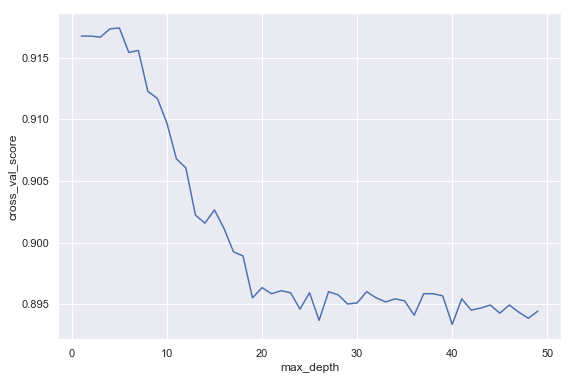

In [671]:
sns.lineplot(x='max_depth', y='cross_val_score', data=scores_data)

In [675]:
scores_data.sort_values('cross_val_score', ascending=False).head()

,max_depth,cross_val_score
0,5,0.917421
0,4,0.917338
0,1,0.916757
0,2,0.916757
0,3,0.916674


In [677]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=5)
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [679]:
clf.score(X_test, y_test)

0.9272237196765498

Или то же самое с помощью `GridSearchCV`:

In [684]:
from sklearn.model_selection import GridSearchCV

In [686]:
clf = DecisionTreeClassifier()
parametrs = {'criterion': ['gini', 'entropy'], 'max_depth': range(1,30)}

In [688]:
grid_search_cv_clf = GridSearchCV(clf, parametrs, cv=5)
grid_search_cv_clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': range(1, 30)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [689]:
grid_search_cv_clf.best_params_

{'criterion': 'entropy', 'max_depth': 5}

In [690]:
best_clf = grid_search_cv_clf.best_estimator_

In [691]:
best_clf.score(X_test, y_test)

0.9272237196765498

In [693]:
y_pred = best_clf.predict(X_test)

## Найдем метрики качества

In [694]:
from sklearn.metrics import precision_score, recall_score

In [695]:
precision_score(y_test, y_pred)

0.4642857142857143

In [696]:
recall_score(y_test, y_pred)

0.15402843601895735

In [699]:
y_predicted_prob =  best_clf.predict_proba(X_test)

In [706]:
y_pred = np.where(y_predicted_prob[:, 1] > 0.5, 1, 0)
print("precision:", precision_score(y_test, y_pred), "\nrecall:", recall_score(y_test, y_pred))

precision: 0.4642857142857143 
recall: 0.15402843601895735


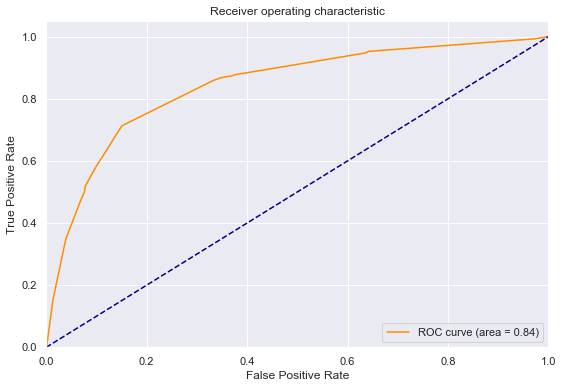

In [707]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_predicted_prob[:,1])
roc_auc= auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',
          label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()